In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os

from IPython.display import display, HTML
BASE_FOLDER = ".."
CONFIGURATION_INPUT_FILE = "configuration-input-new.csv"
COMPONENT_TO_ANALYZE = "host" # host / server / service
CHUNK_SIZE = 1000

In [2]:
def list_directories(directory):
    return [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

In [3]:
def most_recent_directory(directory):
    dirs = list_directories(directory)
    if not dirs:
        return None
    
    most_recent = max(dirs, key=lambda d: os.path.getctime(os.path.join(directory, d)))
    return os.path.join(directory, most_recent)

In [4]:
def mean_of_chunks(series, chunk_size):
    # Explicitly setting numeric_only to True to avoid FutureWarning about deprecation
    return series.groupby(np.arange(len(series)) // chunk_size).mean(numeric_only=True)

In [5]:
def retrieve_metrics():
    input_path = f"{BASE_FOLDER}/input/{CONFIGURATION_INPUT_FILE}"
    with open(input_path, 'r') as file:
        lines = file.readlines()
        second_line = lines[1]  # get the second line
        second_line_elements = second_line.split(',')  # split the line by comma

    df = pd.read_csv(input_path, sep=",")
    all_metrics = []
    read_value = ""
    found_number = False
    index_of_metrics = len(df.columns) - 2

    while not found_number:
        read_value = df.iloc[0, index_of_metrics]
        try:
            int(read_value)
            found_number = True
        except ValueError:
            all_metrics.append(df.iloc[0, index_of_metrics])
            index_of_metrics -= 1

    return all_metrics[::-1]

all_metrics = retrieve_metrics()

In [6]:
all_performance_metrics = ['cpu_limit', 'cpu_usage', 'cpu_demand', 'cpu_utilization', 'cpu_time_active', 'cpu_time_idle', 'cpu_time_steal', 'cpu_time_lost']
all_energy_metrics = ['power_total']
        
selected_performance_metrics = [metric for metric in all_metrics if metric in all_performance_metrics]
selected_energy_metrics = [metric for metric in all_metrics if metric in all_energy_metrics]

print(selected_performance_metrics)
print(selected_energy_metrics)

['cpu_time_steal', 'cpu_limit']
['power_total']


In [7]:
path = f"{BASE_FOLDER}/output/{COMPONENT_TO_ANALYZE}/workload=bitbrains-small/seed=0/"

recent_dir = most_recent_directory(path)
simulation_files = os.listdir(recent_dir)
simulation_data = []
virgin_simulation_data = []

for file in simulation_files:
    simulation_data.append(
        mean_of_chunks(pd.read_parquet(os.path.join(recent_dir, file)), CHUNK_SIZE)
    )
    virgin_simulation_data.append(
        pd.read_parquet(os.path.join(recent_dir, file))
    )
    
simulation_data[0]

,cpu_count,mem_capacity,guests_terminated,guests_running,guests_error,guests_invalid,cpu_limit,cpu_usage,cpu_demand,cpu_utilization,cpu_time_active,cpu_time_idle,cpu_time_steal,cpu_time_lost,power_total,uptime,downtime
0,12.440000,99520.000000,0.0,3.66300,0.0,0.0,38367.280000,8770.896777,8770.896777,0.085653,822.219000,2909.780000,2.503,0.0,63854.153841,300000.000000,0.0
1,12.440000,99520.000000,0.0,3.66300,0.0,0.0,38367.280000,10742.637750,10742.637750,0.104909,1006.984000,2725.016000,58.817,0.0,64720.238559,300000.000000,0.0
2,12.448000,99584.000000,0.0,3.66300,0.0,0.0,38395.040000,10698.257832,10698.257832,0.104475,1002.827000,2731.573000,148.083,0.0,64700.748745,300000.000000,0.0
3,12.440000,99520.000000,0.0,3.66300,0.0,0.0,38367.280000,7842.166107,7842.166107,0.076584,735.386000,2996.614000,0.000,0.0,63447.122317,300000.000000,0.0
4,12.464000,99712.000000,0.0,3.69600,0.0,0.0,38446.240000,2688.921989,2688.921989,0.026259,252.086000,3487.114000,0.000,0.0,61181.654903,300000.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,12.448000,99584.000000,0.0,1.22100,0.0,0.0,38395.040000,1194.767614,1194.767614,0.011668,112.067000,3622.332000,0.000,0.0,60525.316085,300000.000000,0.0
152,12.440000,99520.000000,0.0,1.22100,0.0,0.0,38367.280000,1350.904083,1350.904083,0.013192,126.310000,3605.691000,0.000,0.0,60592.075841,300000.000000,0.0
153,12.440000,99520.000000,0.0,1.22100,0.0,0.0,38367.280000,1270.154718,1270.154718,0.012404,118.952000,3613.048000,0.000,0.0,60557.586120,300000.000000,0.0
154,12.440000,99520.000000,0.0,1.22100,0.0,0.0,38367.280000,1274.991616,1274.991616,0.012451,119.719000,3612.281000,0.000,0.0,60561.184164,300000.000000,0.0


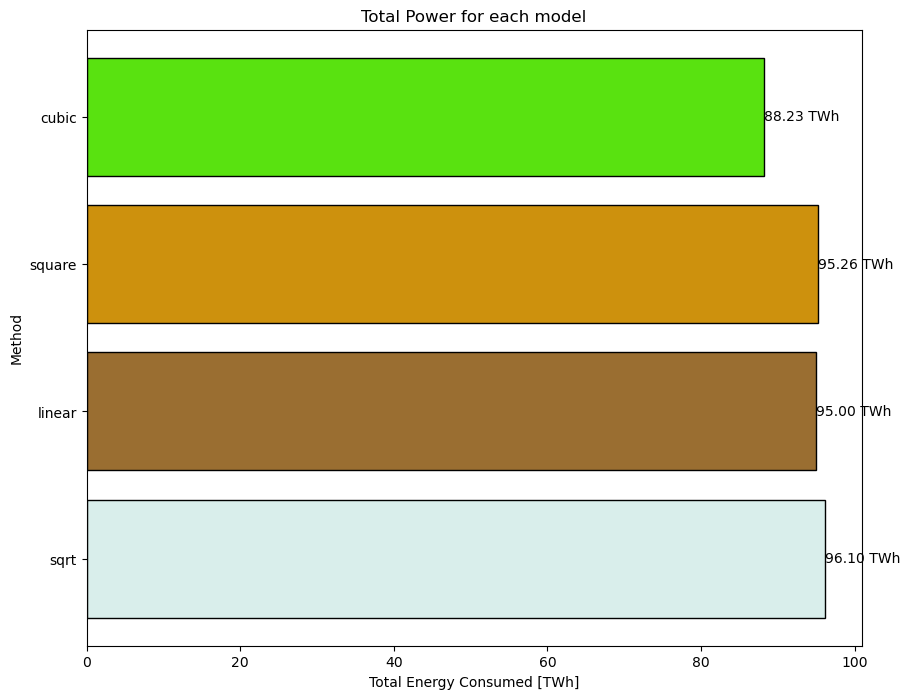

In [8]:
"""
plotter has data taken and averaged over CHUNK_SIZE
virgin_plotter has data taken without averaging
"""

from plotter import DataPlotter
plotter = DataPlotter(simulation_data)
virgin_plotter = DataPlotter(virgin_simulation_data)

# for metric in selected_performance_metrics:
#     if metric == 'cpu_limit':
#         plotter.plot_cpu_limit()
#     elif metric == 'cpu_usage':
#         plotter.plot_cpu_usage()
#     elif metric == 'cpu_demand':
#         plotter.plot_cpu_demand()
#     elif metric == 'cpu_utilization':
#         plotter.plot_cpu_utilization()
#     elif metric == 'cpu_time_active':
#         plotter.plot_cpu_time_active()
#     elif metric == 'cpu_time_idle':
#         plotter.plot_cpu_time_idle()
#     elif metric == 'cpu_time_steal':
#         plotter.plot_cpu_time_steal()
#     elif metric == 'cpu_time_lost':
#         plotter.plot_cpu_time_lost()
#     elif metric == 'mem_capacity':
#         plotter.plot_mem_capacity()
        
for metric in selected_energy_metrics:
    if metric == 'power_total':
        virgin_plotter.plot_power_total()

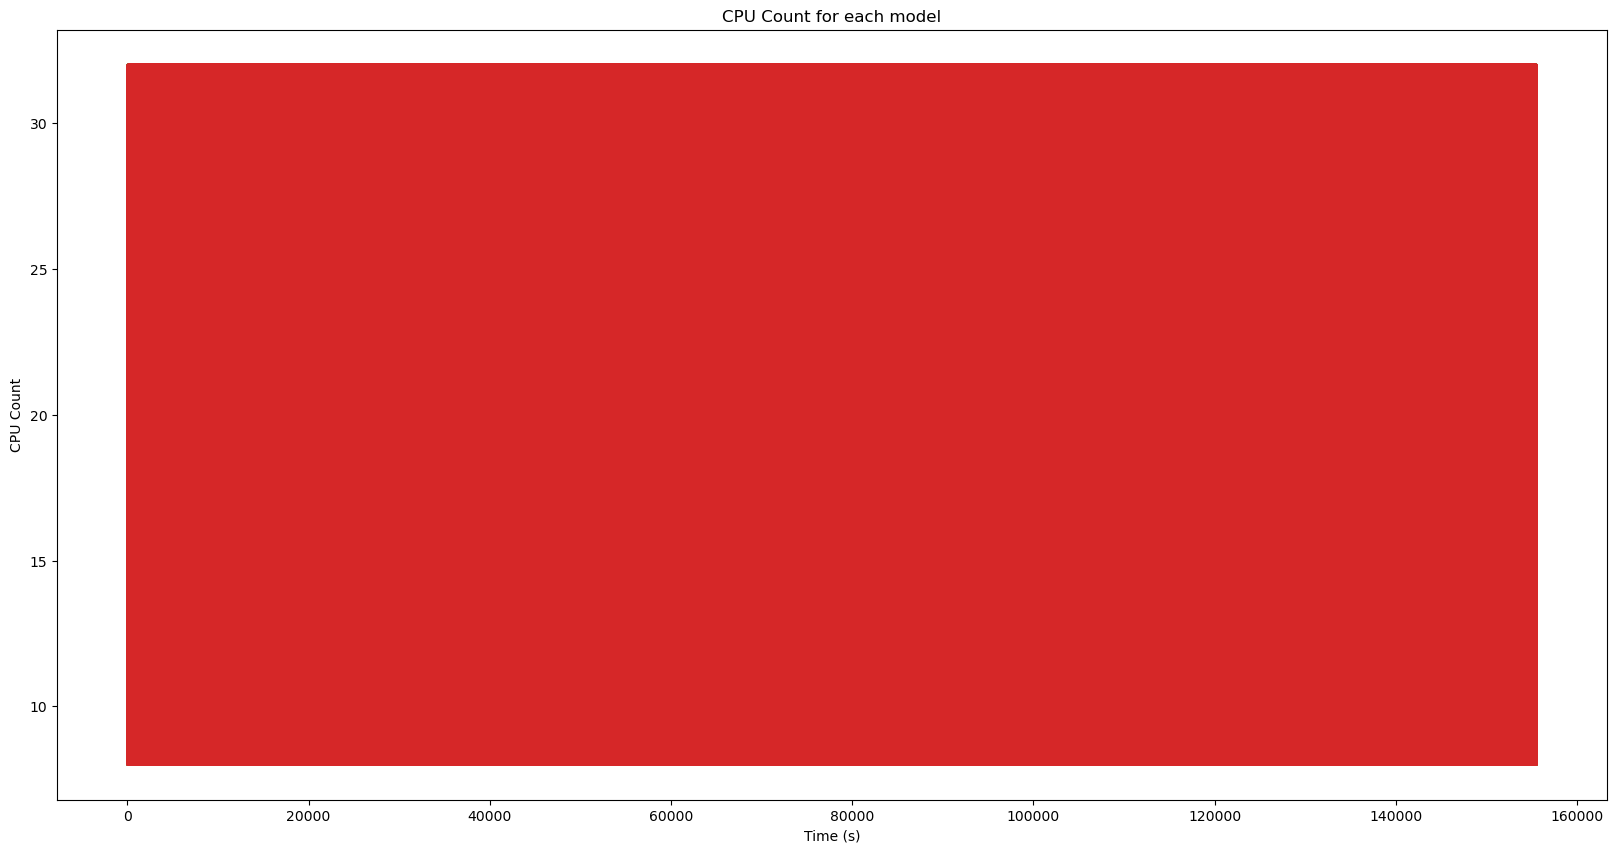

KeyboardInterrupt: 

In [35]:
from plotter import DataPlotter
plotter = DataPlotter(simulation_data)


if (COMPONENT_TO_ANALYZE == "server"):
    plotter.plot_mem_capacity()
    plotter.plot_cpu_count()
    plotter.plot_cpu_limit()
    plotter.plot_cpu_time_active()
    plotter.plot_cpu_time_idle()
    plotter.plot_cpu_time_steal()
    plotter.plot_cpu_time_lost()
elif (COMPONENT_TO_ANALYZE == "host"):
    plotter.plot_cpu_count()
    plotter.plot_mem_capacity()
    plotter.plot_guests_terminated()
    plotter.plot_guests_running()
    plotter.plot_guests_error()
    plotter.plot_guests_invalid()
    plotter.plot_cpu_limit()
    plotter.plot_cpu_usage()
    plotter.plot_cpu_demand()
    plotter.plot_cpu_utilization()
    plotter.plot_cpu_time_steal()
    plotter.plot_servers_active()
    plotter.plot_cpu_time_idle()
    plotter.plot_cpu_time_lost()
    plotter.plot_power_total()
elif (COMPONENT_TO_ANALYZE == "service"):
    plotter.plot_hosts_up()
    plotter.plot_hosts_down()
    plotter.plot_servers_pending()
    plotter.plot_servers_active()
    plotter.plot_attempts_success()
    plotter.plot_attempts_failure()
    plotter.plot_attempts_error()